<a href="https://colab.research.google.com/github/vubanc/BikeTimeSeriesAnalysis/blob/main/TimeSeriesAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing the Libraries and Notebooks**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [53]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [75]:
df = pd.read_csv("/content/drive/MyDrive/Work/Bikesharing/CombinedRentals_AllStations.csv")
df.head(2)

,index,id,user,user_id,user_phone,start_station,start_time,start_time_local,end_station,end_time,end_time_local,kilometers,miles,message_count,type,duration (seconds),rating,device_id,bike_type,Date
0,1,34ac1576-891f-4aca-a570-31db6160fd6f,Dara Ochoa,2112677d-b644-4cb8-866d-58f52b932f76,14792852353,Riverfront Park,2023-08-02 01:09:31.952446+00:00,2023-08-01 19:09:31.952446-06:00,Riverfront Park,2023-08-02 01:10:19.952446+00:00,2023-08-01 19:10:19.952446-06:00,NaN,NaN,130,22,48.0,NaN,74164be4e769c0ff30f08acb19724fa186d89b71913e9b...,Regular Bike,2023-08-01
1,2,dc96b3e6-f607-452b-ad18-79ea96e033d9,Gervon Pennington,79ea58b0-0988-47da-b963-a11a52a94f04,19035560048,Riverfront Park,2023-08-02 00:48:53.349677+00:00,2023-08-01 18:48:53.349677-06:00,Riverfront Park,2023-08-02 01:24:14.349677+00:00,2023-08-01 19:24:14.349677-06:00,4.482,2.78498,41,22,2121.0,NaN,fMV1Kdc8Km,Regular Bike,2023-08-01


## **Exploratory Data Analysis**

In [76]:
min_date = df.Date.min()
max_date = df.Date.max()
dates = pd.DataFrame(pd.date_range(start=min_date, end=max_date))
dates.rename(columns={0:"Date"}, inplace=True)
dates.Date = dates.Date.dt.strftime("%Y-%m-%d")
df = pd.merge(df, dates, how="right", on="Date")
df.sort_values(by = ["Date", "start_time"], inplace=True, ascending=[True,True])
df_tripCount = df.groupby("Date", as_index=False)["id"].count()
df_tripCount.rename(columns={"id":"trip_count"}, inplace=True)
df_tripCount.Date = pd.to_datetime(df_tripCount.Date)

Trend

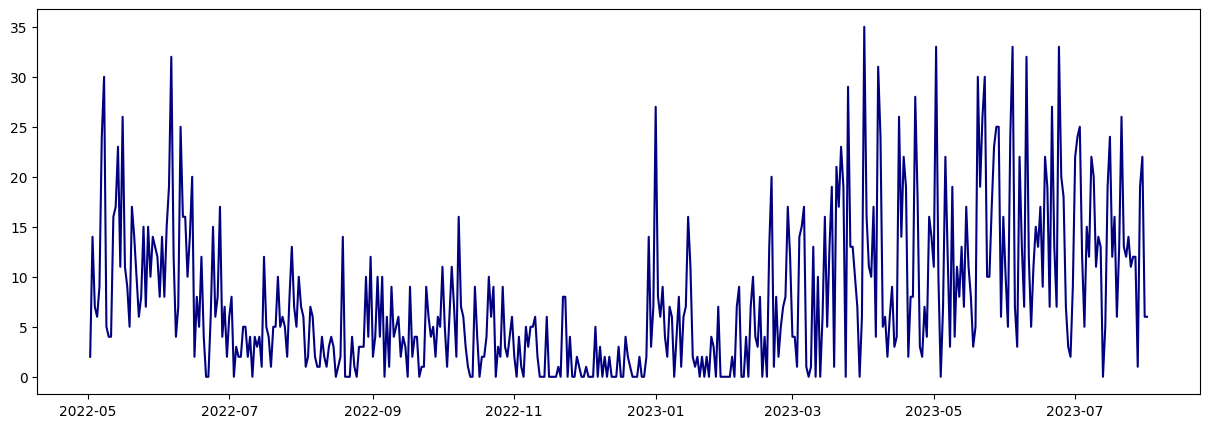

In [77]:
fig, axs = plt.subplots(1,1, figsize=(15,5))
plt.plot(df_tripCount['Date'].to_list(), df_tripCount['trip_count'].to_list(), color="navy")

Autocorrelation

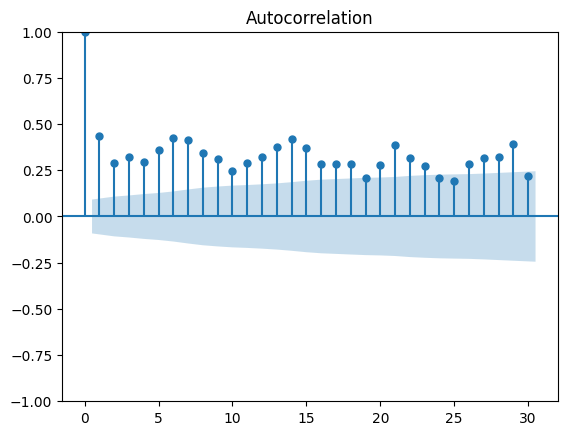

In [81]:
df_tripCount.set_index("Date")
acf_plot = plot_acf(df_tripCount.trip_count, lags=30)

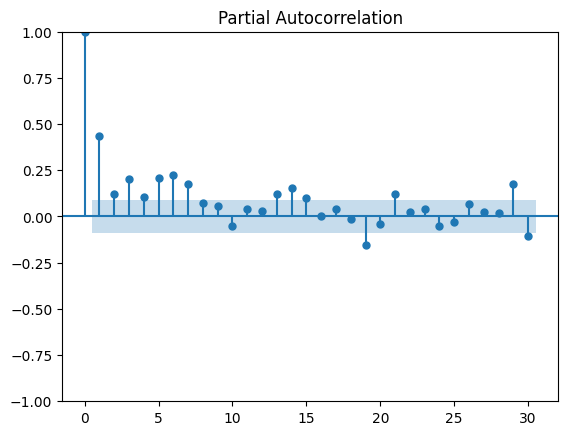

In [84]:
pacf_plot = plot_pacf(df_tripCount.trip_count, lags=30)

Stationarity

In [101]:
print(f"Global Mean: {df_tripCount.trip_count.mean()}")
print(f"Global Mean: {df_tripCount[250:].trip_count.mean()}")

Global Mean: 7.899343544857768
Global Mean: 10.734299516908212
